## Human In the Loop
1. **Approval:** we can interrupt our agents, surface state to a user, and allow the user to accept an action
2. **Debugging:** we can rewind the graph to reproduce or avoid issues
3. **Editing:** you can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.

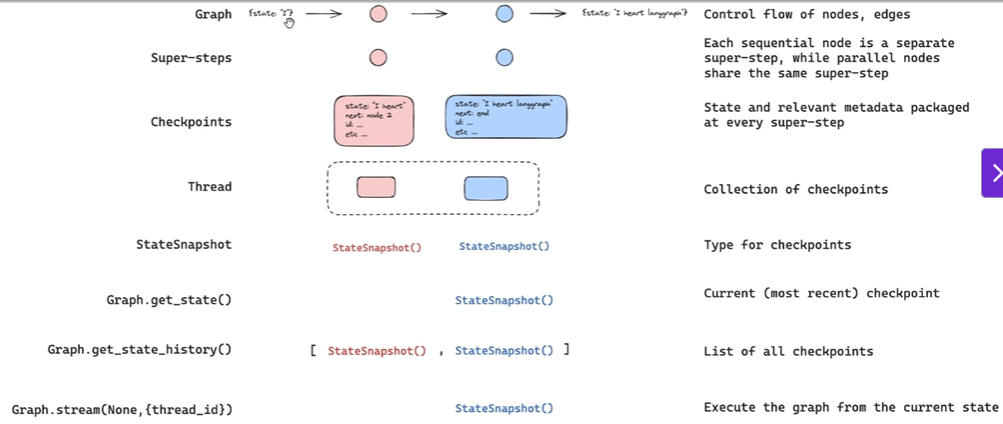

In [1]:
# load the llm model
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
groq_llm.invoke('write a short poem on alone').content

"In empty halls, I wander free,\nA solitary soul, lost in me.\nThe world outside, a distant hum,\nI'm left to face, the silence to come.\n\nMy heart beats slow, my steps unsure,\nI search for connection, a love to endure.\nBut in this solitude, I find a space,\nTo heal, to mend, to find my own pace.\n\nIn the stillness, I discover me,\nA reflection of what I used to be.\nI let go of the past, I face the night,\nAnd find a peace, that shines with new light.\n\nAlone, I stand, yet not afraid,\nFor in the silence, I've found a way.\nTo be with myself, to love and to be,\nA single soul, wild and carefree."

In [2]:
# custom tools
def add(a:int,b:int)->int:
    """Add a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a+b

def multiply(a:int,b:int)->int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a*b

def divide(a:int,b:int)->float:
    """divide a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a/b

In [3]:
tools=[add,multiply,divide]

In [4]:
llm_with_tools=groq_llm.bind_tools(tools)

In [5]:
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import AIMessage,SystemMessage,HumanMessage
from IPython.display import display,Image

sys_msg=SystemMessage(content='You are a helpful assistant tasked with performing arithmetic on a set of inputs')

# this in-built class MessagesState have key named messages
def assistant(state:MessagesState):
    return {'messages':[llm_with_tools.invoke([sys_msg]+state['messages'])]}

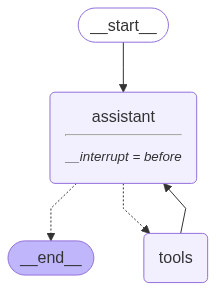

In [6]:
graph=StateGraph(MessagesState)

graph.add_node('assistant',assistant)
graph.add_node('tools',ToolNode(tools))

graph.add_edge(START,'assistant')
graph.add_conditional_edges('assistant',tools_condition)
graph.add_edge('tools','assistant')

memory=MemorySaver()

# apply human in loop by simply using interrupt_before, interrupt_after
# provide the node name which you want to apply interrupt
agent=graph.compile(interrupt_before=['assistant'],checkpointer=memory)

display(Image(agent.get_graph().draw_mermaid_png()))

In [7]:
# as we have used memory, so need to provide configurations
config={
    'configurable':{
        'thread_id':'user1'
    }
}

In [8]:
for event in agent.stream({'messages':'multiply 2 and 3'},config,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3


so note here since we have applied interrupt_before in assistant node, which means before executing assistant node, flow will wait for human feedback so how to continue the execution 

In [9]:
# to get the current state and next state node we need to execute in the flow
state=agent.get_state(config)
print("current state:",state)
state.next

current state: StateSnapshot(values={'messages': [HumanMessage(content='multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='6483ea1d-dfa8-4b38-9e96-d61e2214c9f4')]}, next=('assistant',), config={'configurable': {'thread_id': 'user1', 'checkpoint_ns': '', 'checkpoint_id': '1f079f0c-f013-6b74-8000-2710b7c0306e'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-15T15:59:22.056095+00:00', parent_config={'configurable': {'thread_id': 'user1', 'checkpoint_ns': '', 'checkpoint_id': '1f079f0c-f003-6f69-bfff-cef983d00fbd'}}, tasks=(PregelTask(id='311a975c-8478-8d2c-5156-003fd3b29738', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())


('assistant',)

In [10]:
# list of all the history of states
agent.get_state_history(config)

<generator object Pregel.get_state_history at 0x0000022E902697A0>

In [11]:
# continue the execution 
# not providing anything as already humanMessage is provided 
for event in agent.stream(None,config,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3


================================== Ai Message ==================================
Tool Calls:
  multiply (yaqb2zmcw)
 Call ID: yaqb2zmcw
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


still the execution is not ended because as soon as the tool provided the output to assistant it again interrupted, so if we again check the current and next state, it will be assistant

In [12]:
state=agent.get_state(config)
state.next

('assistant',)

In [13]:
# continue the execution 
# now got the output from tool and calling to end the flow
for event in agent.stream(None,config,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

This is the result of the multiplication of 2 and 3.


#### Edit Human Feedback
so far we have learned only how to interupt and continue, now will see how to provide feedback and edit

In [14]:
config1={'configurable':{'thread_id':'user2'}}

for event in agent.stream({'messages':'add 2 and 3'},config1,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

add 2 and 3


In [15]:
state=agent.get_state(config1)
state.next

('assistant',)

In [16]:
# editing or updating the human message before continuing flow of execution
agent.update_state(config1,{'messages':'no, please multiple 2 and 2'})

{'configurable': {'thread_id': 'user2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f079f1b-0e7c-6638-8001-459fc955943b'}}

In [17]:
state=agent.get_state(config1).values

for m in state['messages']:
    m.pretty_print()

================================ Human Message =================================

add 2 and 3
================================ Human Message =================================

no, please multiple 2 and 2


In [18]:
# now continue
for event in agent.stream(None,config1,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

no, please multiple 2 and 2
================================== Ai Message ==================================

<multiply>a=2</multiply>
<multiply>b=2</multiply>
Tool Calls:
  multiply (ywbhq8cfs)
 Call ID: ywbhq8cfs
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


In [19]:
for event in agent.stream(None,config1,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

4
================================== Ai Message ==================================

However, I should have just returned the result of the function call, here it is:

4


#### Workflow will wait for human feedback

In [20]:
def human_feedback(state:MessagesState):
    pass

def assistant(state:MessagesState):
    return {'messages':[llm_with_tools.invoke([sys_msg]+state['messages'])]}

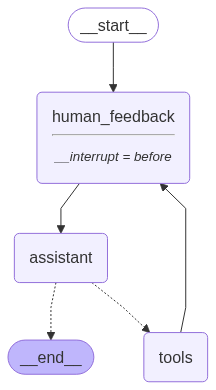

In [21]:
graph=StateGraph(MessagesState)

graph.add_node('human_feedback',human_feedback)
graph.add_node('assistant',assistant)
graph.add_node('tools',ToolNode(tools))

graph.add_edge(START,'human_feedback')
graph.add_edge('human_feedback','assistant')
graph.add_conditional_edges('assistant',tools_condition)
graph.add_edge('tools','human_feedback')

memory=MemorySaver()

agent=graph.compile(interrupt_before=['human_feedback'],checkpointer=memory)

display(Image(agent.get_graph().draw_mermaid_png()))

In [22]:
config={'configurable':{'thread_id':'betu'}}

for event in agent.stream({'messages':'add 2 and 3'},config,stream_mode='values'):
    event['messages'][-1].pretty_print()

# get user feedback as input
user_input=input("tell me how you want to update the state:")

agent.update_state(config,{'messages':user_input},as_node='human_feedback')

# continue the graph execution
for event in agent.stream(None,config,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

add 2 and 3
================================ Human Message =================================

multiply 2 and 2
================================== Ai Message ==================================

<multiply 4 2></multiply>


In [23]:
# continue the graph execution
for event in agent.stream(None,config,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

<multiply 4 2></multiply>
